In [1]:
import os
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split

In [2]:
con1 = sqlite3.connect('group3_collected_data\group3_collected_data-000037.db')
df1 = pd.read_sql_query('SELECT * FROM COUNTERS_STRING_TIME_DATA', con1)
df2 = pd.read_sql_query('SELECT COUNTERS_STRING_TIME_DATA.*, INPUTS.INPUT_DESCRIPTION FROM COUNTERS_STRING_TIME_DATA LEFT JOIN INPUTS WHERE COUNTERS_STRING_TIME_DATA.ID_INPUT == INPUTS.ID_INPUT', con1)

In [3]:
df2

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA,INPUT_DESCRIPTION
0,2021-11-20 21:30:29.491,2,IDC_ARROW,0,Mouse cursor icon state.
1,2021-11-20 21:30:30.578,3,cmd.exe,0,Foreground window .exe process.
2,2021-11-20 21:30:31.512,2,IDC_SIZEWE,0,Mouse cursor icon state.
3,2021-11-20 21:30:31.847,2,IDC_ARROW,0,Mouse cursor icon state.
4,2021-11-20 21:30:34.994,2,IDC_HAND,0,Mouse cursor icon state.
...,...,...,...,...,...
3101,2021-11-22 23:28:39.479,3,cmd.exe,0,Foreground window .exe process.
3102,2021-11-22 23:28:40.427,3,SearchApp.exe,0,Foreground window .exe process.
3103,2021-11-22 23:28:41.652,3,StartMenuExperienceHost.exe,0,Foreground window .exe process.
3104,2021-11-22 23:28:42.054,2,IDC_APPSTARTING,0,Mouse cursor icon state.


# Reading Data using Pandas and SQLite3

In [4]:
# helper function to join tables across different database (.db) files
def join_tables(tables):
    
    df = tables[0]
    for table in tables[1:]:
        df = pd.concat([df, table])
        
    return df.reset_index(drop=True)

# joining all database (.db) files of folder
def get_all_databases(folder):
    
    string_tables = []
    ull_tables = []
    files = os.listdir(folder)
    
    # iterating through all files of folder to append tables
    for file in files:
        path = os.path.join(folder, file)
        con = sqlite3.connect(path)
        string_tables.append(pd.read_sql_query('SELECT COUNTERS_STRING_TIME_DATA.*, INPUTS.INPUT_DESCRIPTION FROM COUNTERS_STRING_TIME_DATA LEFT JOIN INPUTS WHERE COUNTERS_STRING_TIME_DATA.ID_INPUT == INPUTS.ID_INPUT', con))
        ull_tables.append(pd.read_sql_query('SELECT COUNTERS_ULL_TIME_DATA.*, INPUTS.INPUT_DESCRIPTION FROM COUNTERS_ULL_TIME_DATA LEFT JOIN INPUTS WHERE COUNTERS_ULL_TIME_DATA.ID_INPUT == INPUTS.ID_INPUT', con))
        
    # concatenating tables into single DataFrames
    string_df = join_tables(string_tables)
    string_df.loc[:, 'VALUE'] = string_df.loc[:, 'VALUE'].replace({'WWAHost.exe': 'Netflix.exe'}) 
    string_df.loc[:, 'VALUE'] = string_df.loc[:, 'VALUE'].str.lower()
    string_df.loc[string_df['INPUT_DESCRIPTION'] == 'Mouse cursor icon state.', 'ID_INPUT'] = 2
    string_df.loc[string_df['INPUT_DESCRIPTION'] == 'Foreground window .exe process.', 'ID_INPUT'] = 3
    ull_df = join_tables(ull_tables)
    ull_df.loc[ull_df['INPUT_DESCRIPTION'] == 'Mouse X position in pixel(s)', 'ID_INPUT'] = 0
    ull_df.loc[ull_df['INPUT_DESCRIPTION'] == 'Mouse Y position in pixel(s)', 'ID_INPUT'] = 1
    ull_df.loc[ull_df['INPUT_DESCRIPTION'] == 'Foreground window is immersive.', 'ID_INPUT'] = 4
    ull_df.loc[ull_df['INPUT_DESCRIPTION'] == 'Foreground window is hung.', 'ID_INPUT'] = 5
    return (string_df.drop('INPUT_DESCRIPTION', axis=1), ull_df.drop('INPUT_DESCRIPTION', axis=1))

In [5]:
# LAPTOP-MP2GILK8
string_df_0, ull_df_0 = get_all_databases('group3_collected_data')

# DESKTOP-E83M0TM
string_df_1, ull_df_1 = get_all_databases('group3_collected_data_pc_1')

In [6]:
display(string_df_0.head())
display(ull_df_0.head())

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA
0,2021-11-20 21:30:29.491,2,idc_arrow,0
1,2021-11-20 21:30:30.578,3,cmd.exe,0
2,2021-11-20 21:30:31.512,2,idc_sizewe,0
3,2021-11-20 21:30:31.847,2,idc_arrow,0
4,2021-11-20 21:30:34.994,2,idc_hand,0


,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA
0,2021-11-20 21:30:29.436,0,791,0
1,2021-11-20 21:30:29.436,1,108,0
2,2021-11-20 21:30:30.442,0,814,0
3,2021-11-20 21:30:30.442,1,70,0
4,2021-11-20 21:30:30.578,4,2072,0


# Exploratory Data Analysis

In [7]:
# getting value counts of foreground applications on LAPTOP-MP2GILK8
foreground_0 = string_df_0[string_df_0['ID_INPUT'] == 3]['VALUE'].value_counts()
foreground_0

chrome.exe                              1526
explorer.exe                             945
discord.exe                              371
zoom.exe                                 339
devenv.exe                               323
cmd.exe                                  293
teams.exe                                245
spotify.exe                              192
db browser for sqlite.exe                164
msedge.exe                               110
shellexperiencehost.exe                  106
systemsettings.exe                        85
netflix.exe                               67
screenclippinghost.exe                    67
vsdebugconsole.exe                        50
searchapp.exe                             50
steamwebhelper.exe                        32
sndvol.exe                                32
microsoft.aad.brokerplugin.exe            30
steam.exe                                 23
python.exe                                17
javaw.exe                                 16
taskmgr.ex

In [8]:
# getting value counts of foreground applications on DESKTOP-E83M0TM
foreground_1 = string_df_1[string_df_1['ID_INPUT'] == 3]['VALUE'].value_counts()
foreground_1

chrome.exe                              610
explorer.exe                            435
discord.exe                             246
cmd.exe                                 181
spotify.exe                             113
among us.exe                             82
shellexperiencehost.exe                  74
steamwebhelper.exe                       74
msedge.exe                               72
sndvol.exe                               65
searchapp.exe                            60
systemsettings.exe                       52
radeonsoftware.exe                       49
video.ui.exe                             46
csgo.exe                                 36
applicationframehost.exe                 27
startmenuexperiencehost.exe              25
r5apex.exe                               24
steam.exe                                21
zoom.exe                                 18
python.exe                               18
hxoutlook.exe                            14
pythonw.exe                     

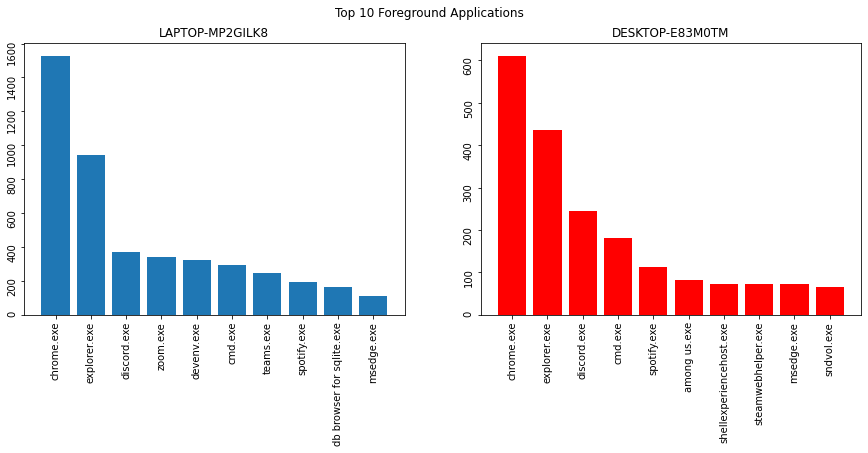

In [9]:
# plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Top 10 Foreground Applications')

ax1.bar(x=foreground_0.index[:10], height=foreground_0.values[:10])
ax1.tick_params(rotation=90);
ax1.set_title('LAPTOP-MP2GILK8');

ax2.bar(x=foreground_1.index[:10], height=foreground_1.values[:10], color='red')
ax2.tick_params(rotation=90);
ax2.set_title('DESKTOP-E83M0TM');

In [10]:
# getting value counts of mouse icons on LAPTOP-MP2GILK8
icon_0 = string_df_0[string_df_0['ID_INPUT'] == 2]['VALUE'].value_counts()

# getting value counts of mouse icons on DESKTOP-E83M0TM
icon_1 = string_df_1[string_df_1['ID_INPUT'] == 2]['VALUE'].value_counts()

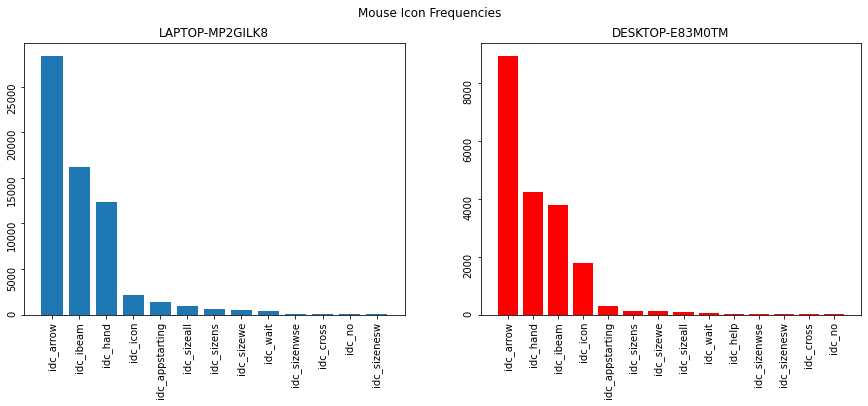

In [11]:
# plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Mouse Icon Frequencies')

ax1.bar(x=icon_0.index, height=icon_0.values)
ax1.tick_params(rotation=90);
ax1.set_title('LAPTOP-MP2GILK8');

ax2.bar(x=icon_1.index, height=icon_1.values, color='red')
ax2.tick_params(rotation=90);
ax2.set_title('DESKTOP-E83M0TM');

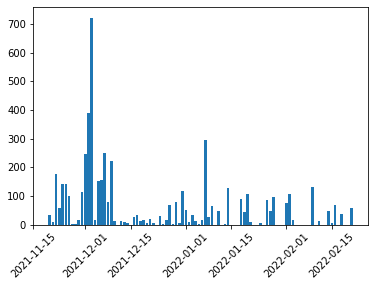

In [12]:
string_df_0['MEASUREMENT_TIME'] = string_df_0['MEASUREMENT_TIME'].apply(lambda x: pd.to_datetime(x).date())
foreground_0 = string_df_0[string_df_0['ID_INPUT'] == 3].groupby('MEASUREMENT_TIME').agg('count')['VALUE']
plt.bar(x=foreground_0.index, height=foreground_0.values)
plt.xticks(rotation=45);

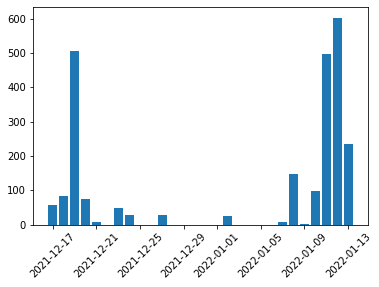

In [13]:
string_df_1['MEASUREMENT_TIME'] = string_df_1['MEASUREMENT_TIME'].apply(lambda x: pd.to_datetime(x).date())
foreground_1 = string_df_1[string_df_1['ID_INPUT'] == 3].groupby('MEASUREMENT_TIME').agg('count')['VALUE']
plt.bar(x=foreground_1.index, height=foreground_1.values)
plt.xticks(rotation=45);

# Problem 1
Predict the likelihood of using an application given the previous sequence of application usage.

In [14]:
from collections import defaultdict

def get_totals(df):
    
    sequence = df[df['ID_INPUT'] == 3]['VALUE'].values
    pairs = defaultdict(int)

    for i in range(len(sequence)-1):
        pairs[(sequence[i], sequence[i+1])] += 1

    return pairs

def get_cond_probs(df):
    
    cond_probs = defaultdict(list)
    foregrounds = df[df['ID_INPUT'] == 3]['VALUE'].value_counts()
    pairs = sorted(get_totals(df).items(), key=lambda x: (x[0][0], -x[1]))
    # pairs = get_app_totals(df)

    for (pair, freq) in pairs:
        cond_probs[pair[0]].append((pair[1], round(freq/foregrounds[pair[0]], 3)))

    return cond_probs

def get_cond_prob_plots(df):

    cond_probs = get_cond_probs(df)
    for app in cond_probs:
        series = pd.DataFrame(cond_probs[app])
        plt.figure(figsize=(8, 6))
        plt.bar(x=series[0], height=series[1])
        plt.title(app);
        plt.xticks(rotation=90)
        plt.grid(True, alpha=0.5)
        plt.show()

In [15]:
# LAPTOP-MP2GILK8
get_cond_probs(string_df_0)

# # DESKTOP-E83M0TM
# get_cond_probs(string_df_1)

defaultdict(list,
            {'anaconda3-2021.11-windows-x86_64.exe': [('chrome.exe', 0.5),
              ('cmd.exe', 0.5)],
             'applicationframehost.exe': [('discord.exe', 0.5),
              ('chrome.exe', 0.5)],
             'calculator.exe': [('chrome.exe', 1.0)],
             'chrome.exe': [('explorer.exe', 0.248),
              ('zoom.exe', 0.155),
              ('discord.exe', 0.138),
              ('cmd.exe', 0.069),
              ('spotify.exe', 0.06),
              ('devenv.exe', 0.05),
              ('msedge.exe', 0.047),
              ('teams.exe', 0.045),
              ('shellexperiencehost.exe', 0.033),
              ('screenclippinghost.exe', 0.031),
              ('db browser for sqlite.exe', 0.02),
              ('searchapp.exe', 0.018),
              ('netflix.exe', 0.018),
              ('notepad.exe', 0.007),
              ('microsoft.aad.brokerplugin.exe', 0.006),
              ('systemsettings.exe', 0.005),
              ('steam.exe', 0.004),
          

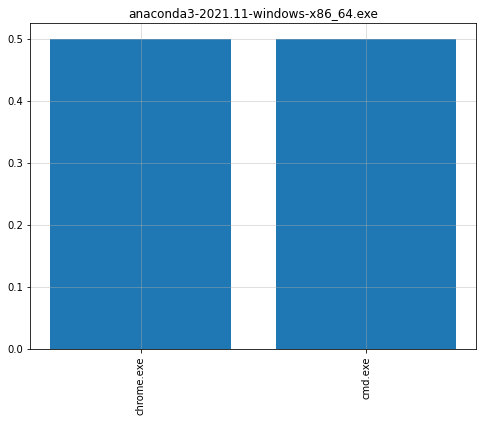

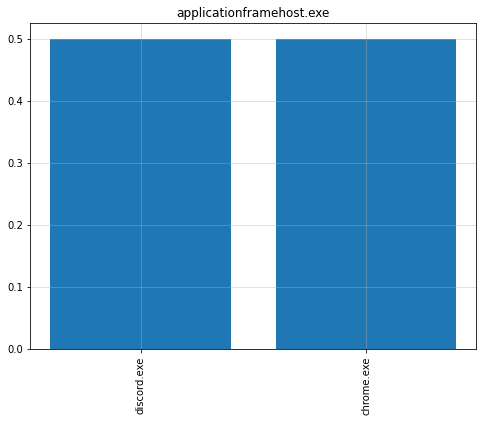

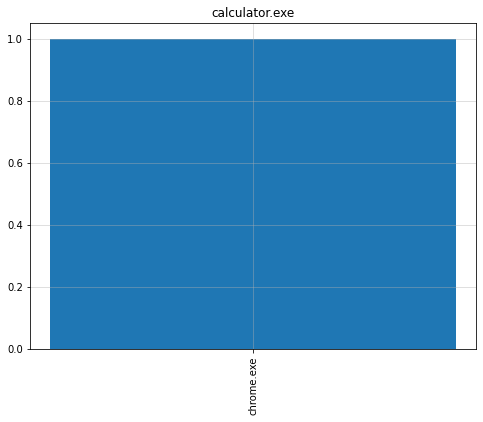

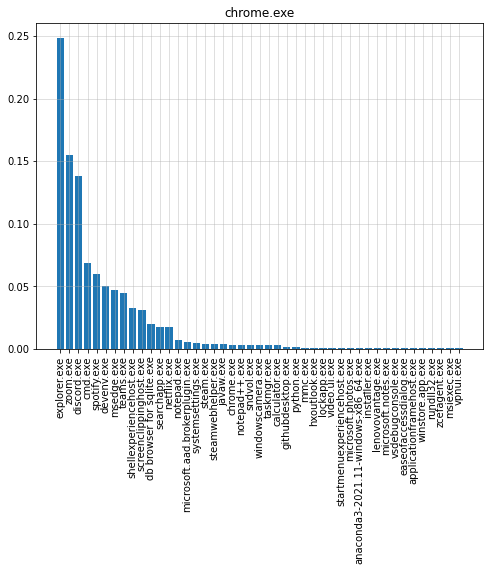

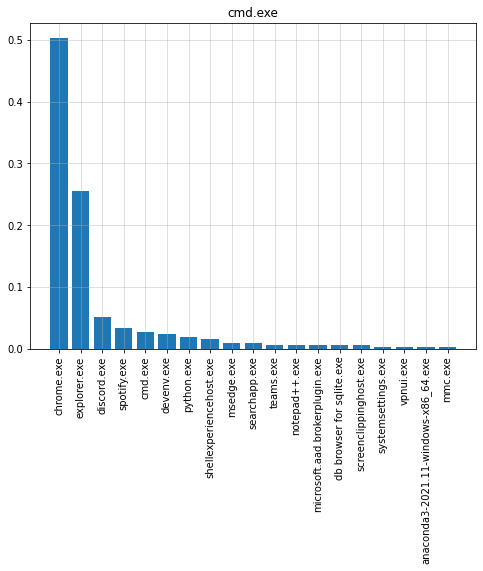

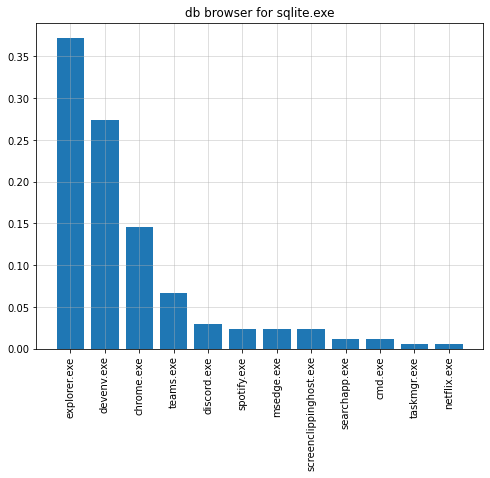

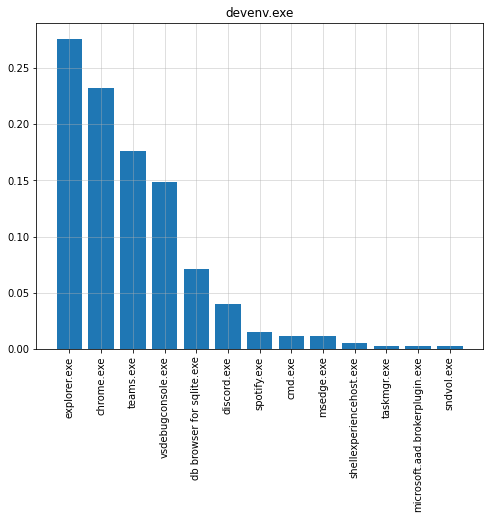

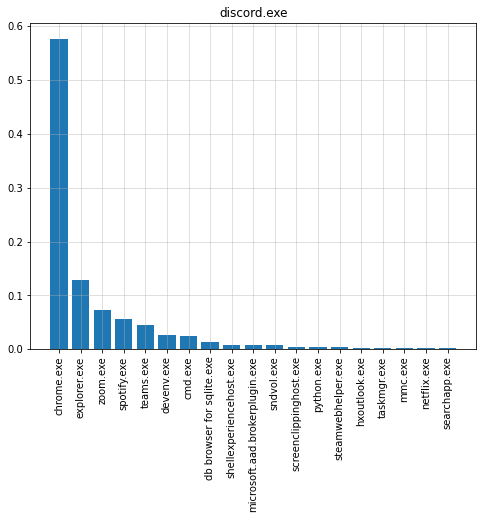

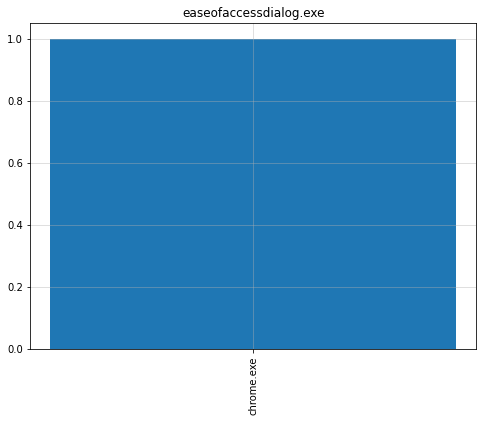

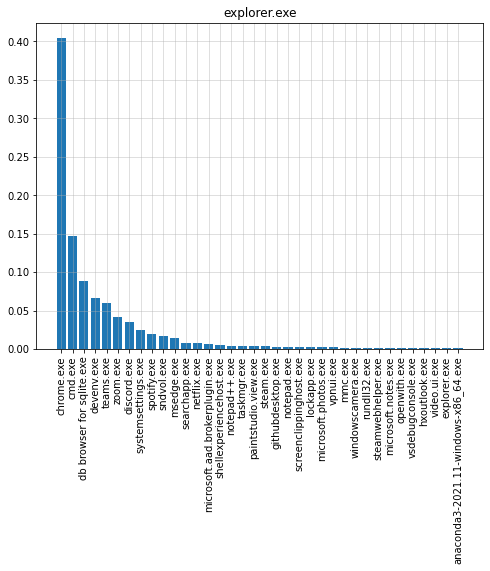

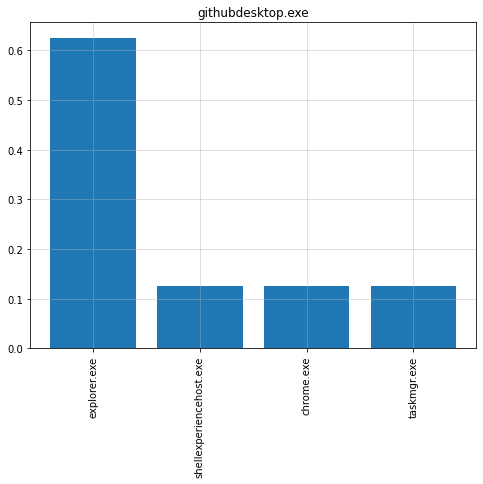

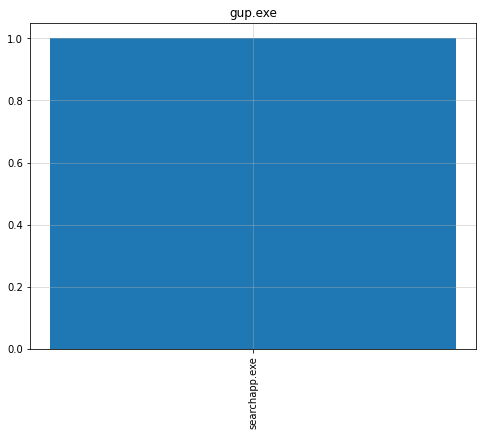

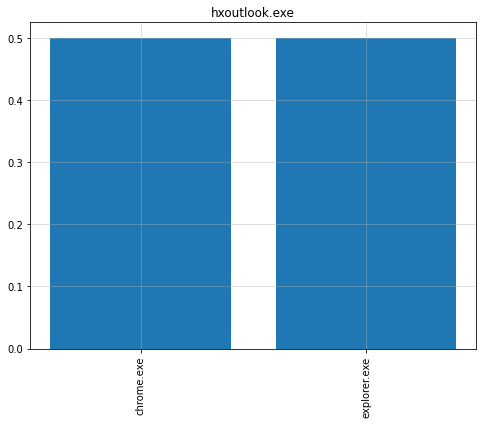

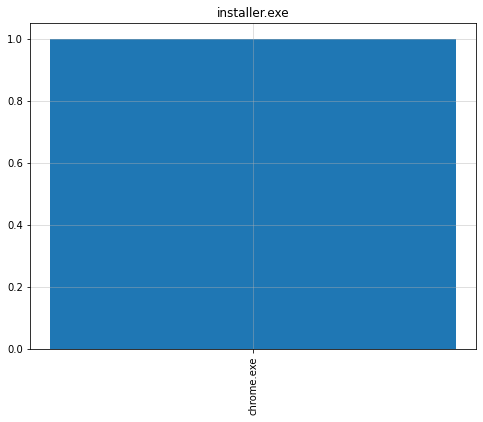

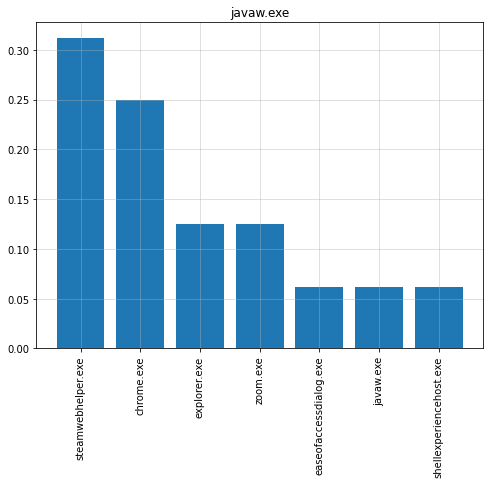

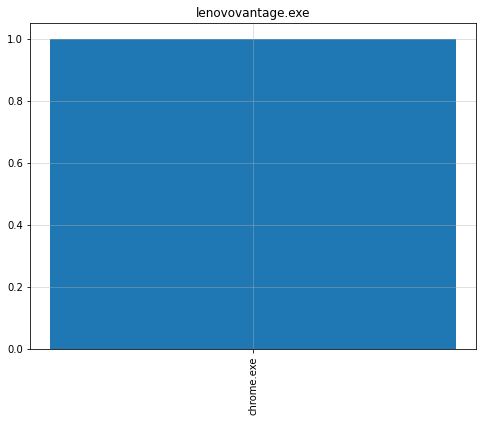

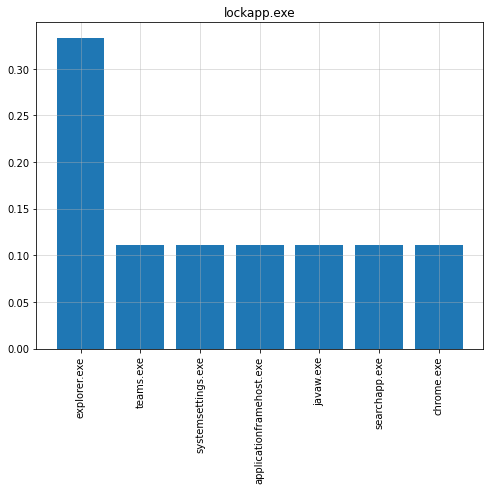

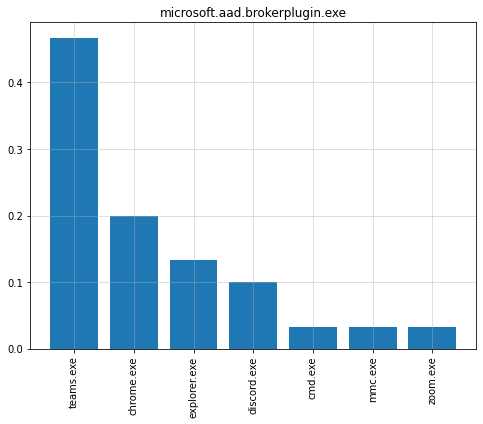

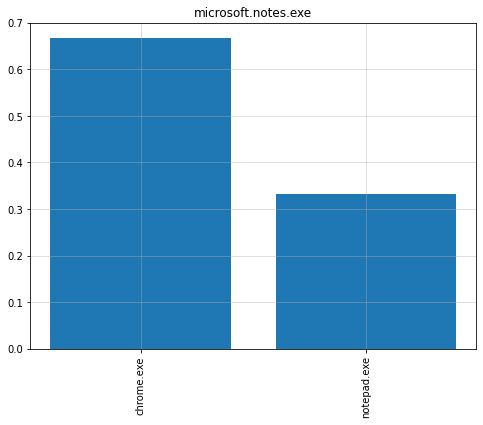

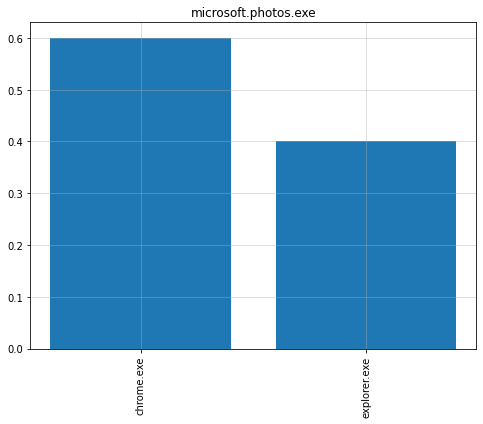

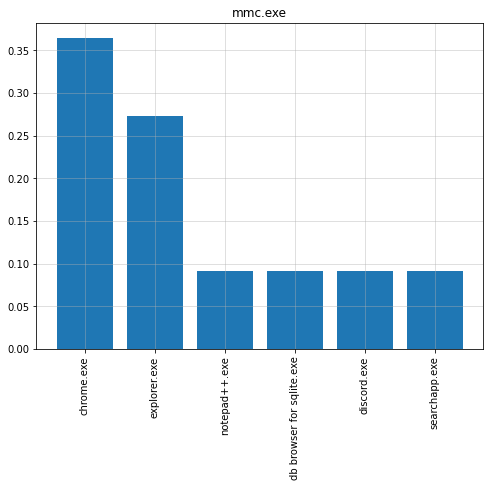

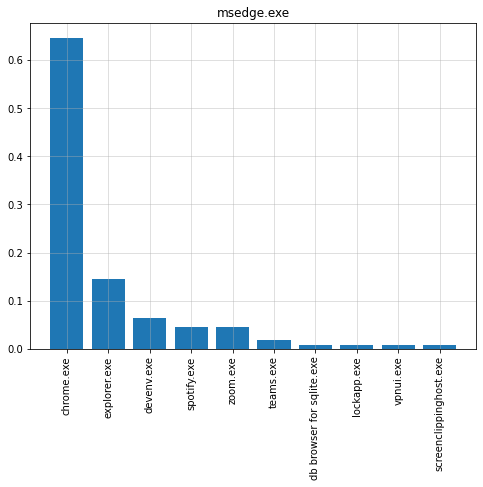

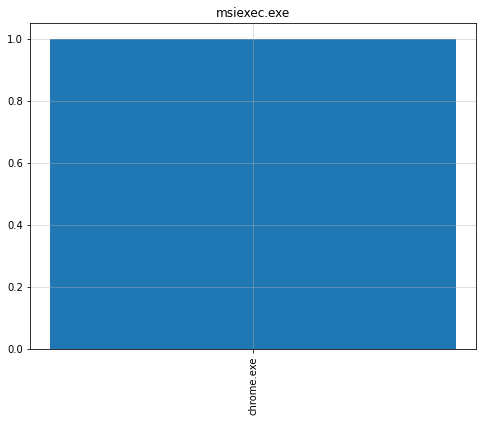

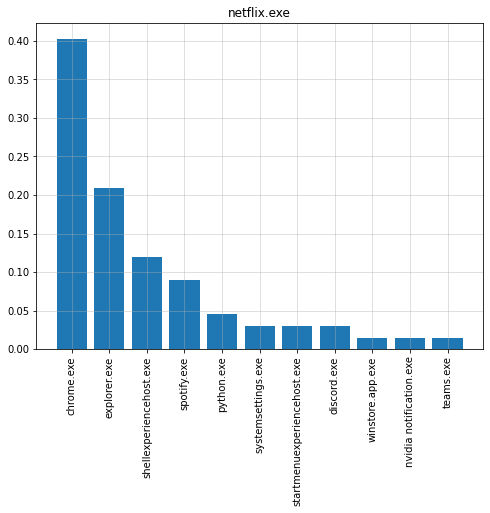

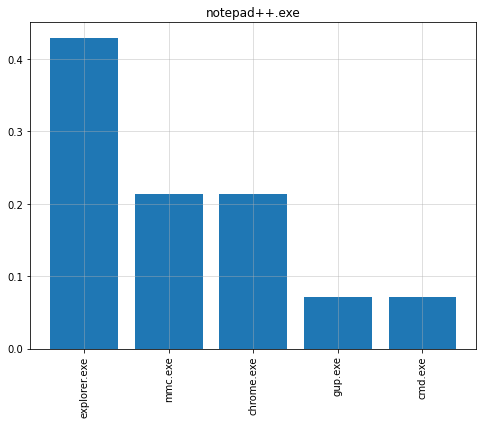

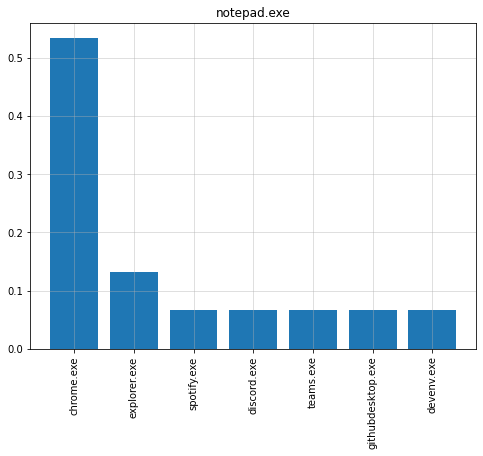

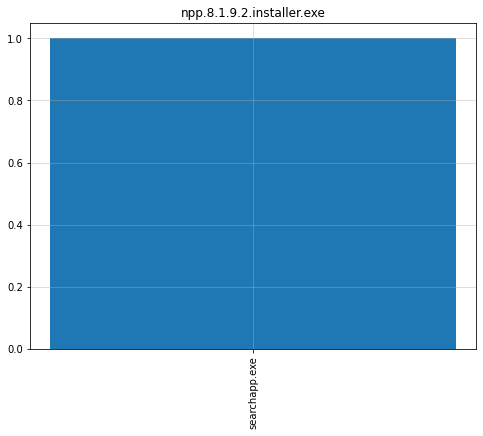

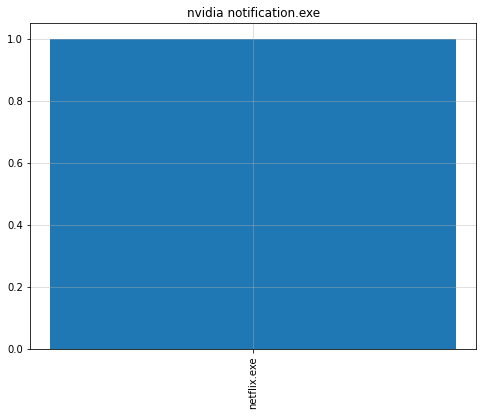

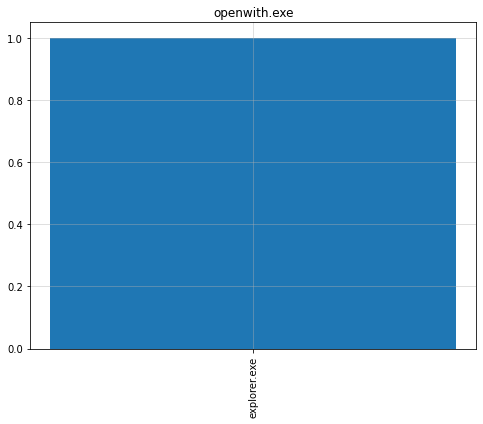

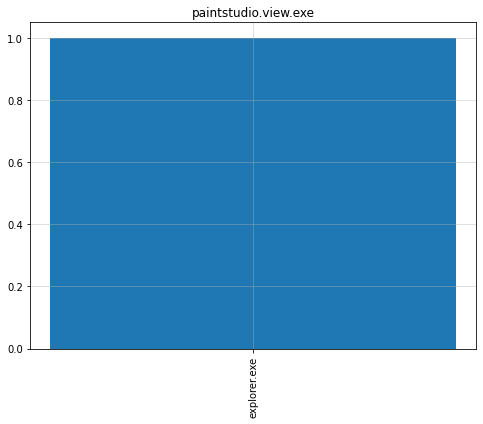

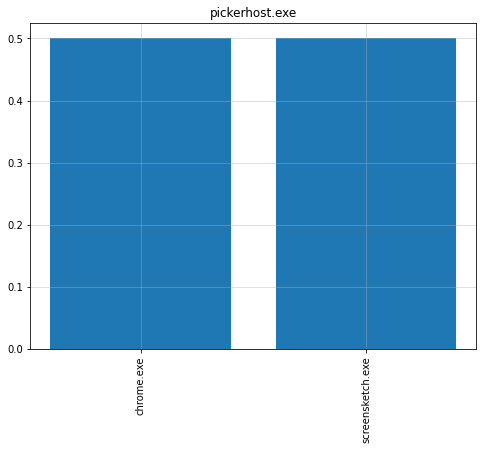

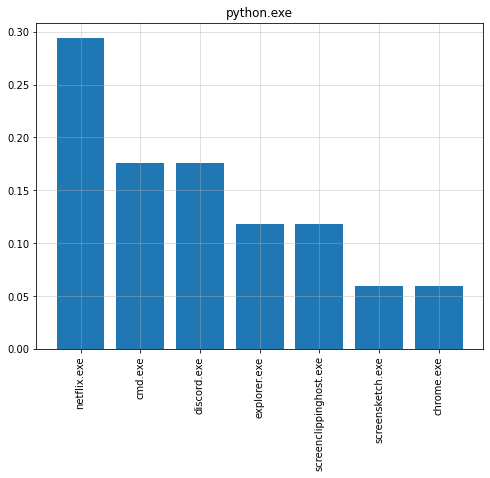

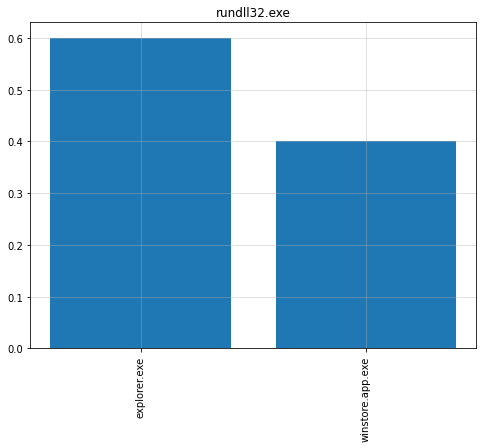

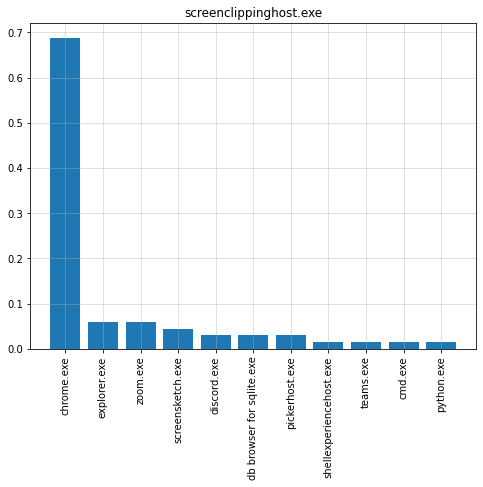

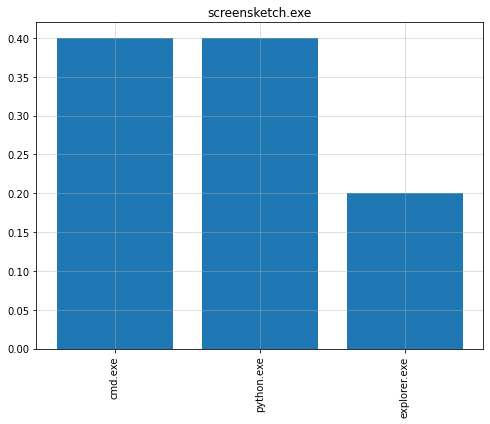

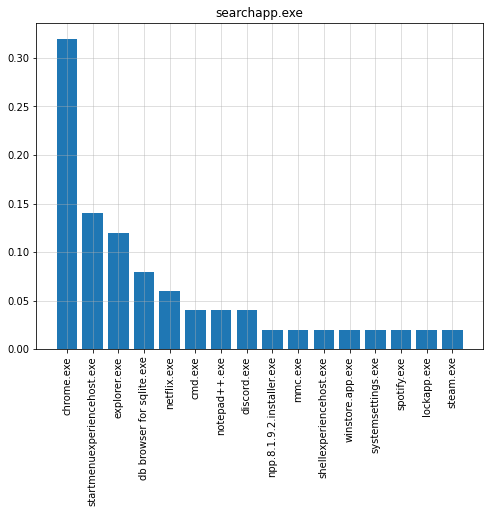

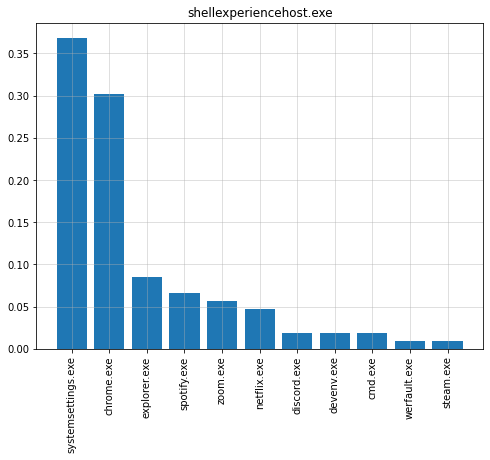

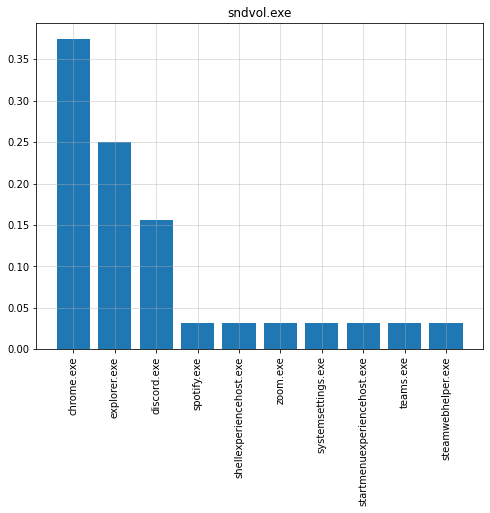

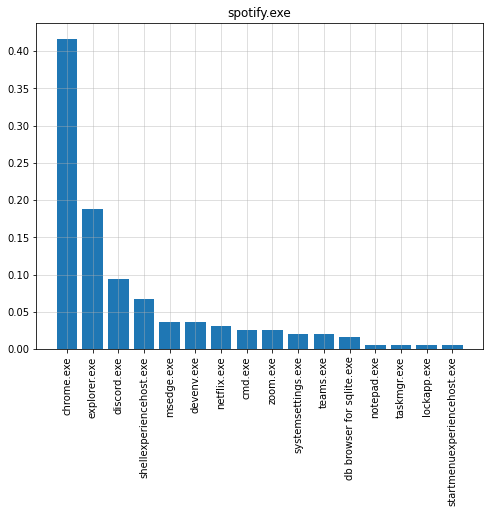

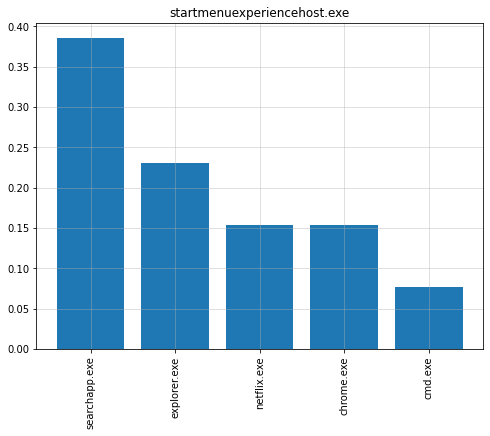

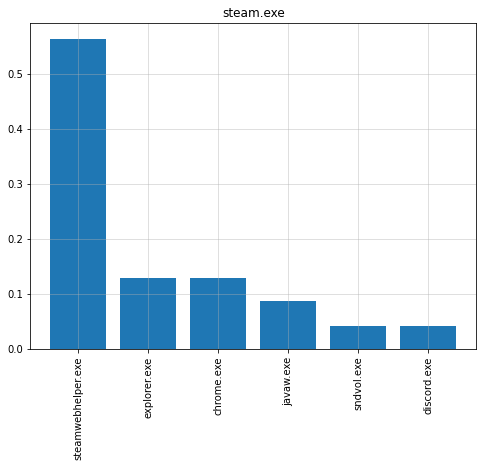

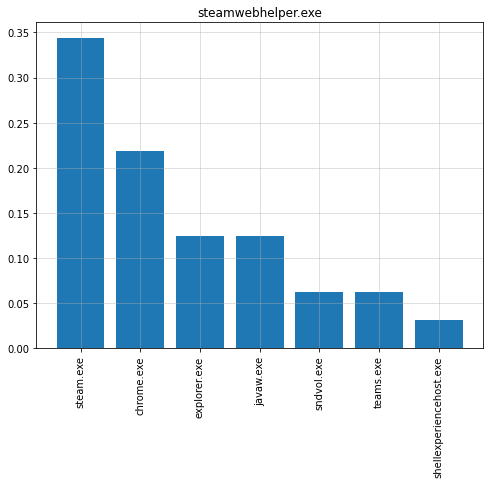

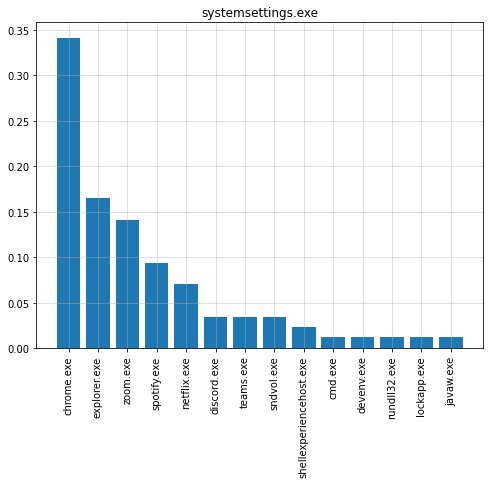

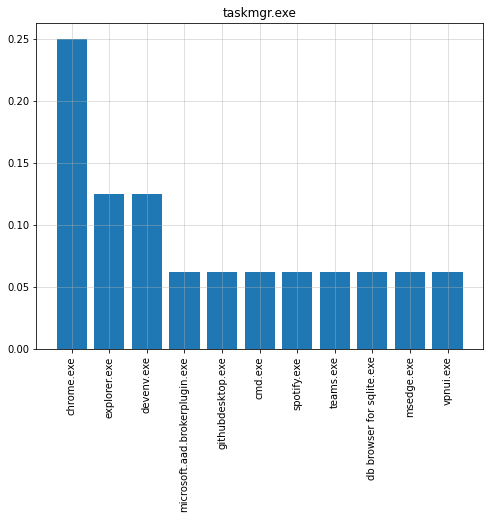

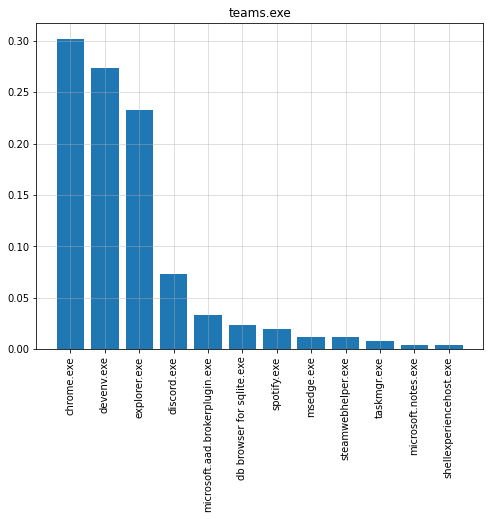

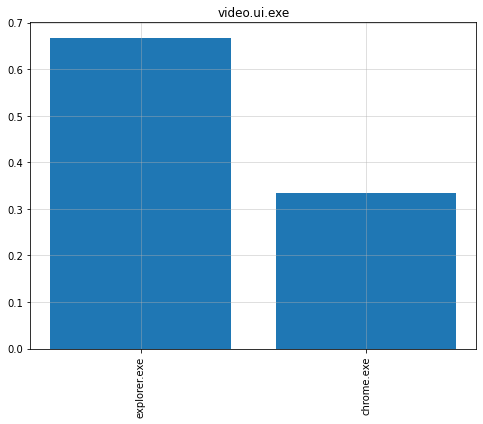

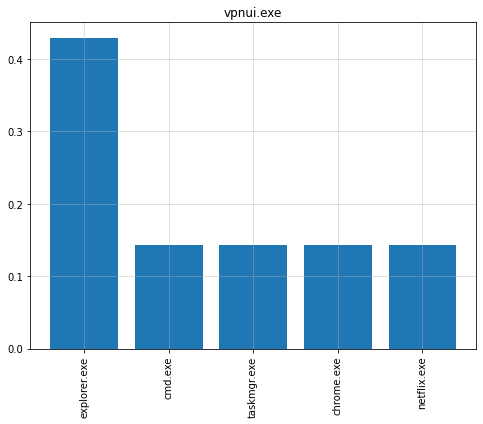

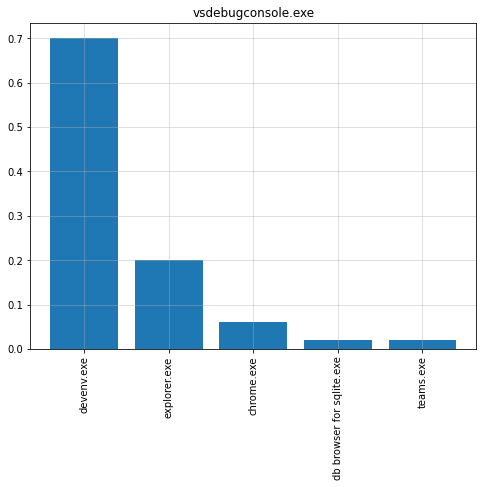

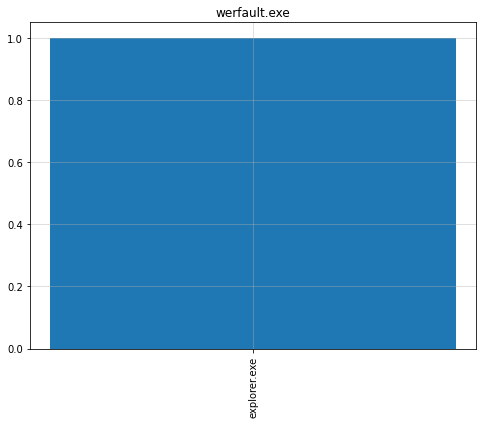

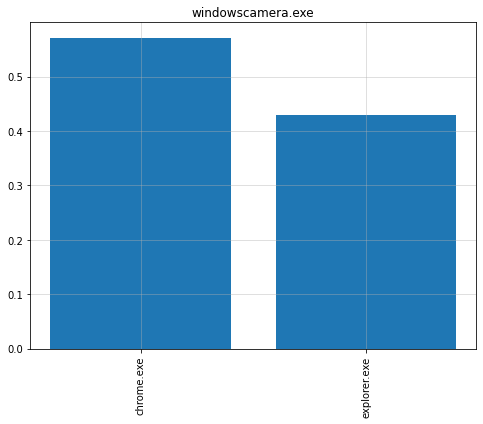

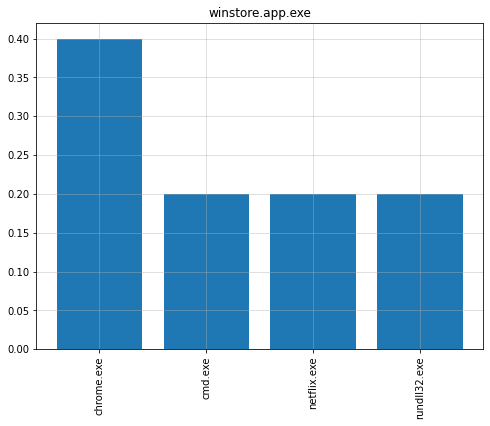

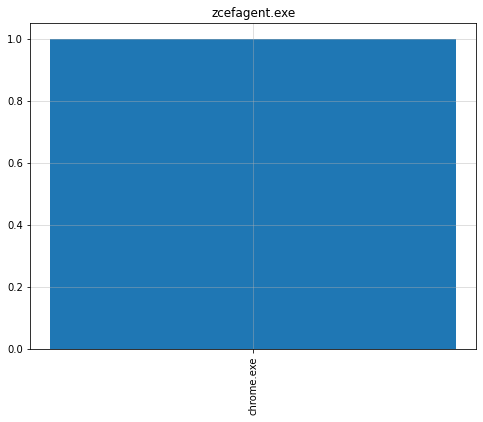

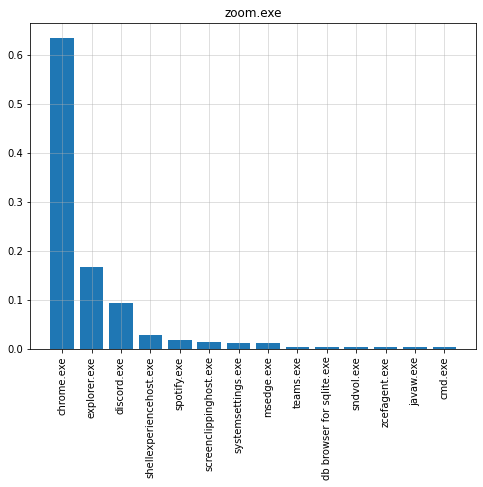

In [16]:
# LAPTOP-MP2GILK8
get_cond_prob_plots(string_df_0)

# # DESKTOP-E83M0TM
# get_cond_prob_plots(string_df_1)

In [17]:
def clean(df, condition_1=True):
    
    sequence = df[df['ID_INPUT'] == 3]['VALUE'].values
    pairs = []
    
    for i in range(len(sequence)-1):
        if condition_1 == True:
            if sequence[i] == sequence[i+1]:
                continue
            else:
                pairs.append([sequence[i], sequence[i+1]])
        else:
            pairs.append([sequence[i], sequence[i+1]])
        
    return pd.DataFrame(pairs, columns=['X', 'y'])

class first_order_HMM(object):
    
    def __init__(self, computer=0):
        if computer == 0:
            self.uniques = sorted(string_df_0[string_df_0['ID_INPUT'] == 3]['VALUE'].unique())
        else:
            self.uniques = sorted(string_df_1[string_df_1['ID_INPUT'] == 3]['VALUE'].unique())
        self.data = pd.DataFrame()
        self.counts = defaultdict(float)
        self.priors = defaultdict(float)
        self.posteriors = defaultdict(float)

    def fit(self, X, y):
        """
        inputs :
            X : a list of prior foreground applications
            y : a list of subsequent foreground applications from the prior foreground applications
            
        outputs:
            None
        """
        
        self.data = pd.DataFrame({'X': X, 'y': y})
        
        def get_counts():
            counts = defaultdict(float)
            for foreground in self.data.values:
                counts[foreground[0]] += 1
            counts[self.data.values[-1][1]] += 1
            return pd.Series(dict(sorted(counts.items())))
        
        def get_priors():
            priors = defaultdict(float)
            # getting percentage of each unique foreground's occurrence
            for foreground, count in self.counts.items():
                priors[foreground] = count / (len(self.data.values) + 1)
            return pd.Series(priors)

        def get_posteriors():
            # creating empty conditional probability matrix
            posteriors = pd.DataFrame(
                np.zeros([len(self.uniques), len(self.uniques)]), 
                index=self.uniques, 
                columns=self.uniques
            )           
            # counting pairs of foregrounds
            for pair in self.data.values:
                posteriors.loc[pair[0], pair[1]] += 1
            # calculating conditional probability of foreground A given foreground B
            posteriors = posteriors.apply(lambda x: x / sum(x), axis=1)
            return posteriors
        
        self.counts = get_counts()
        self.priors = get_priors()
        self.posteriors = get_posteriors()
    
    def predict(self, X, n_foregrounds=1):
        """
        inputs :
            X : a list of prior foreground applications
            n_foregrounds : number of predicted foregrounds to return (default: 1)
            
        outputs :
            y : a list of predicted subsequent foreground applications 
        """
        
        # outputting foreground application with maximum conditional probability
        y = []
        for x in X:
            # outputting foreground application with maximum conditional probability
            # y = np.append(y, self.posteriors.loc[x,:].idxmax())
            y.append(list(self.posteriors.loc[x,:].sort_values(ascending=False)[:n_foregrounds].index))
            
        return y
            
    def accuracy(self, y_test, y_pred):
        """
        inputs :
            y_test : a list of true subsequent foreground applications
            y_pred : a list of predicted subsequent foreground applications
            
        outputs :
            accuracy : accuracy of trained model on y_test
        """
        correct = 0
        for i, y in enumerate(y_test):
            if y in y_pred[i]:
                correct += 1
        accuracy = correct / len(y_test)
        
        return accuracy

In [18]:
model = first_order_HMM()
df = clean(string_df_0)
X_train, X_test, y_train, y_test = train_test_split(df['X'], df['y'], test_size=0.2, random_state=99)

model.fit(X_train, y_train)
y_pred = model.predict(X_test, n_foregrounds=3)
accuracy = model.accuracy(y_test, y_pred)
print('Test accuracy: ', accuracy)

Test accuracy:  0.676555023923445


In [19]:
X_test.head()

552                  explorer.exe
2013    db browser for sqlite.exe
322                  explorer.exe
1476                   devenv.exe
2655                   devenv.exe
Name: X, dtype: object

In [20]:
y_test.head()

552             chrome.exe
2013             teams.exe
322            discord.exe
1476    vsdebugconsole.exe
2655            chrome.exe
Name: y, dtype: object

In [21]:
y_pred[:5]

[['chrome.exe', 'cmd.exe', 'db browser for sqlite.exe'],
 ['explorer.exe', 'devenv.exe', 'chrome.exe'],
 ['chrome.exe', 'cmd.exe', 'db browser for sqlite.exe'],
 ['explorer.exe', 'chrome.exe', 'teams.exe'],
 ['explorer.exe', 'chrome.exe', 'teams.exe']]

In [22]:
model.posteriors

,anaconda3-2021.11-windows-x86_64.exe,applicationframehost.exe,calculator.exe,chrome.exe,cmd.exe,db browser for sqlite.exe,devenv.exe,discord.exe,easeofaccessdialog.exe,explorer.exe,...,taskmgr.exe,teams.exe,video.ui.exe,vpnui.exe,vsdebugconsole.exe,werfault.exe,windowscamera.exe,winstore.app.exe,zcefagent.exe,zoom.exe
anaconda3-2021.11-windows-x86_64.exe,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
applicationframehost.exe,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
calculator.exe,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
chrome.exe,0.001657,0.000829,0.003314,0.000000,0.072080,0.018227,0.049710,0.144988,0.000829,0.231152,...,0.002486,0.043911,0.001657,0.000000,0.000829,0.000000,0.004143,0.000829,0.000829,0.164872
cmd.exe,0.004367,0.000000,0.000000,0.519651,0.000000,0.004367,0.021834,0.056769,0.000000,0.262009,...,0.000000,0.008734,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
db browser for sqlite.exe,0.000000,0.000000,0.000000,0.147287,0.007752,0.000000,0.294574,0.038760,0.000000,0.348837,...,0.007752,0.077519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
devenv.exe,0.000000,0.000000,0.000000,0.215094,0.015094,0.056604,0.000000,0.049057,0.000000,0.286792,...,0.000000,0.196226,0.000000,0.000000,0.139623,0.000000,0.000000,0.000000,0.000000,0.000000
discord.exe,0.000000,0.000000,0.000000,0.587413,0.020979,0.013986,0.024476,0.000000,0.000000,0.129371,...,0.003497,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080420
easeofaccessdialog.exe,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
explorer.exe,0.001337,0.000000,0.000000,0.403743,0.139037,0.090909,0.068182,0.036096,0.000000,0.000000,...,0.005348,0.062834,0.001337,0.004011,0.001337,0.000000,0.002674,0.000000,0.000000,0.042781


### Data Validation

In [23]:
# each foreground application's conditional probabilities sum to 1
model.posteriors.sum(axis=1)

anaconda3-2021.11-windows-x86_64.exe    1.0
applicationframehost.exe                1.0
calculator.exe                          1.0
chrome.exe                              1.0
cmd.exe                                 1.0
db browser for sqlite.exe               1.0
devenv.exe                              1.0
discord.exe                             1.0
easeofaccessdialog.exe                  1.0
explorer.exe                            1.0
githubdesktop.exe                       1.0
gup.exe                                 1.0
hxoutlook.exe                           1.0
installer.exe                           1.0
javaw.exe                               1.0
lenovovantage.exe                       0.0
lockapp.exe                             1.0
microsoft.aad.brokerplugin.exe          1.0
microsoft.notes.exe                     1.0
microsoft.photos.exe                    1.0
mmc.exe                                 1.0
msedge.exe                              1.0
msiexec.exe                     

In [24]:
# for i in range(len(string_df_0)-1):
#     if pd.to_datetime(string_df_0.iloc[i, 0]) > pd.to_datetime(string_df_0.iloc[i+1, 0]):
#         print('failed! time is not ascending!')
#         display(string_df_0.iloc[i:i+2])